# SFC PAYGo Solar Credit Repayment Competition  
_**This notebook was run on a local jupyter environment**_

## Project structure

├── data\
│   ├── metadata.csv\
│   ├── SampleSubmission.csv\
│   ├── Test.csv\
│   ├── Train.csv\
│   └── VariablesDefinition.txt\
├── logs\
├── models\
├── src\
│   └── StarterNotebook.ipynb\
└── submissions


## Importing Libraries

In [218]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression

#Regressors
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#Sklearn RegressorChain for the Gradient Boosting Algorithms
from sklearn.multioutput import RegressorChain


import warnings
warnings.filterwarnings(action="ignore")


# Dataset
---
1. Load files
2. Exploratory Data Analysis (EDA)
3. Preprocess data
4. Extract features
5. ML Modeling  
6. Submission

In [79]:
train = pd.read_csv("C:/Users/User/SFC_PAYGo/Train.csv")
metadata = pd.read_csv("C:/Users/User/SFC_PAYGo/metadata.csv")
test = pd.read_csv("C:/Users/User/SFC_PAYGo/Test.csv")
ss = pd.read_csv("C:/Users/User/SFC_PAYGo/SampleSubmission.csv")

In [80]:
ss.shape

(56016, 2)

#### _We want a model that is able to predict for n_months ahead._

_**For this competition, we set n_months to equal 6**_

In [206]:
n_months=6

### Exploratory Data Analysis

In [81]:
pd.set_option('display.max_columns', None)

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28007 entries, 0 to 28006
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                28007 non-null  object 
 1   TransactionDates  28007 non-null  object 
 2   PaymentsHistory   28007 non-null  object 
 3   m1                28007 non-null  float64
 4   m2                28007 non-null  float64
 5   m3                28007 non-null  float64
 6   m4                28007 non-null  float64
 7   m5                28007 non-null  float64
 8   m6                28007 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


In [85]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
m1,28007.0,815.411683,686.130805,1.0,275.0,820.0,1200.0,33890.0
m2,28007.0,807.101617,839.772177,1.0,250.0,800.0,1200.0,94044.0
m3,28007.0,797.641161,696.809281,1.0,220.0,790.0,1200.0,32005.0
m4,28007.0,815.011033,715.582046,1.0,230.0,815.0,1200.0,33403.0
m5,28007.0,827.719463,796.379837,1.0,220.0,840.0,1205.0,64106.0
m6,28007.0,692.115150,1416.301221,1.0,130.0,480.0,915.0,96814.0


In [86]:
train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0


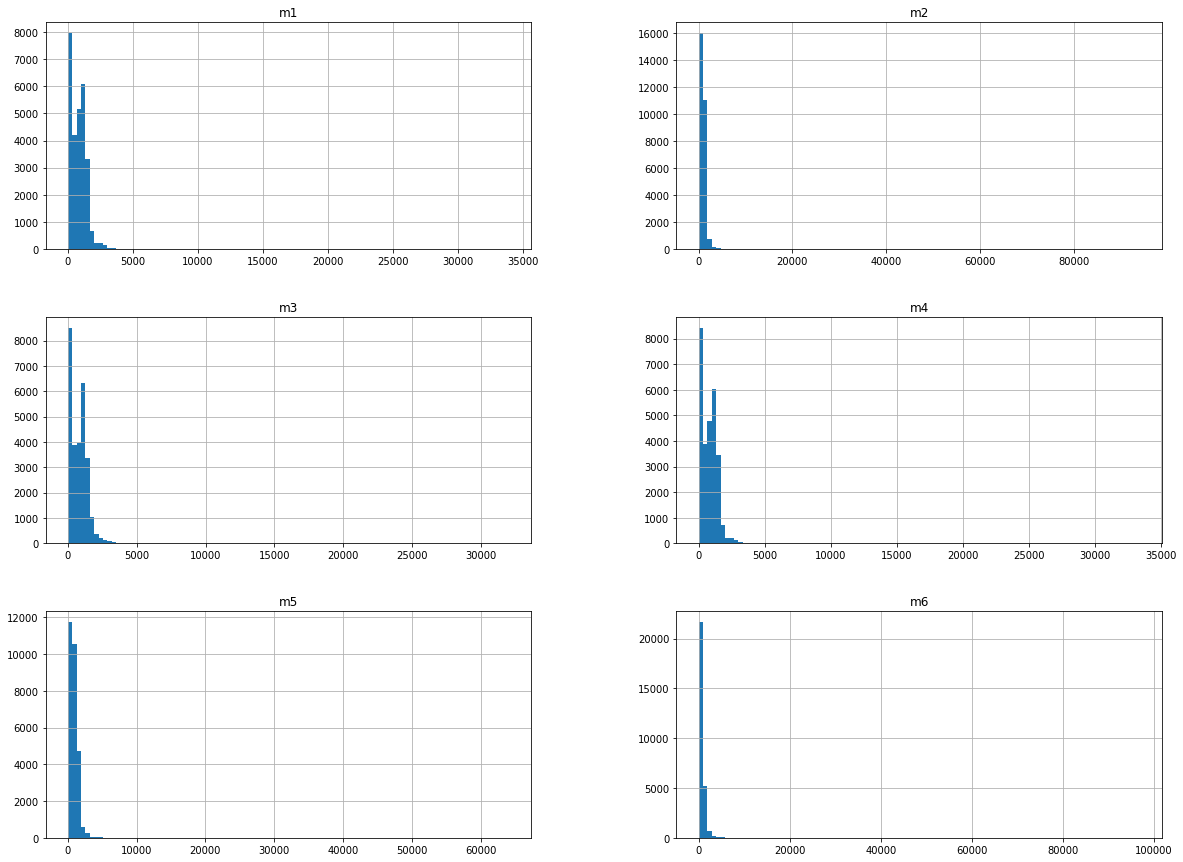

In [94]:
# Getting a feel of the target features
train.hist(bins=100, figsize=(20, 15))
plt.show()

In [95]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37343 entries, 0 to 37342
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37343 non-null  object 
 1   RegistrationDate     37343 non-null  object 
 2   Deposit              37343 non-null  int64  
 3   UpsellDate           973 non-null    object 
 4   AccessoryRate        37343 non-null  float64
 5   PaymentMethod        37343 non-null  object 
 6   rateTypeEntity       37343 non-null  object 
 7   RatePerUnit          37343 non-null  int64  
 8   DaysOnDeposit        37343 non-null  int64  
 9   MainApplicantGender  37343 non-null  object 
 10  Age                  30404 non-null  float64
 11  Region               35409 non-null  object 
 12  Town                 37343 non-null  object 
 13  Occupation           37343 non-null  object 
 14  SupplierName         37343 non-null  object 
 15  Term                 37343 non-null 

### Dropping the Leaked Feature : LastPaymentDate

In [96]:
metadata.drop('LastPaymentDate', axis=1, inplace=True)

In [97]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37343 entries, 0 to 37342
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37343 non-null  object 
 1   RegistrationDate     37343 non-null  object 
 2   Deposit              37343 non-null  int64  
 3   UpsellDate           973 non-null    object 
 4   AccessoryRate        37343 non-null  float64
 5   PaymentMethod        37343 non-null  object 
 6   rateTypeEntity       37343 non-null  object 
 7   RatePerUnit          37343 non-null  int64  
 8   DaysOnDeposit        37343 non-null  int64  
 9   MainApplicantGender  37343 non-null  object 
 10  Age                  30404 non-null  float64
 11  Region               35409 non-null  object 
 12  Town                 37343 non-null  object 
 13  Occupation           37343 non-null  object 
 14  SupplierName         37343 non-null  object 
 15  Term                 37343 non-null 

In [98]:
metadata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Deposit,37343.0,2348.631685,417.814614,0.0,2000.0,2000.0,2500.0,8000.0
AccessoryRate,37343.0,1.136090,7.791789,0.0,0.0,0.0,0.0,240.0
RatePerUnit,37343.0,49.923868,57.500215,35.0,40.0,40.0,55.0,4000.0
DaysOnDeposit,37343.0,4.600835,3.429060,0.0,3.0,3.0,7.0,60.0
Age,30404.0,38.855677,12.300827,19.0,29.0,36.0,46.0,120.0
Term,37343.0,412.427657,121.602544,10.0,364.0,364.0,547.0,626.0
TotalContractValue,37343.0,22953.005142,10149.863172,10800.0,16560.0,16560.0,33080.0,64484.0


In [99]:
metadata.head(n=5)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03
2,ID_102CV85,2015-12-18 00:00:00,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32


In [100]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9336 entries, 0 to 9335
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                9336 non-null   object
 1   TransactionDates  9336 non-null   object
 2   PaymentsHistory   9336 non-null   object
dtypes: object(3)
memory usage: 218.9+ KB


In [102]:
test.describe().transpose()

,count,unique,top,freq
ID,9336,9336,ID_GKVD7B9,1
TransactionDates,9336,2938,"['01-2020', '02-2020', '03-2020', '04-2020', '...",333
PaymentsHistory,9336,9290,"[3500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....",15


In [104]:
test.head(n=5)

,ID,TransactionDates,PaymentsHistory
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]"
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ..."
2,ID_7OU9HLK,"['12-2015', '01-2016', '03-2016', '05-2016', '...","[2400.0, 300.0, 500.0, 450.0, 675.0, 700.0, 87..."
3,ID_WVWTPGK,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4700.0, 1200.0, 950.0, 1200.0, 900.0, 1110.0,..."
4,ID_04DSDQS,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4800.0, 750.0, 995.0, 995.0, 1300.0, 750.0, 1..."


In [105]:
print("---------------- Missing values Report ----------------")
print(train.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
m1                  0
m2                  0
m3                  0
m4                  0
m5                  0
m6                  0
dtype: int64


In [106]:
print("---------------- Missing values Report ----------------")
print(test.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
dtype: int64


In [18]:
print("---------------- Missing values Report ----------------")
print(metadata.isna().sum())

---------------- Missing values Report ----------------
ID                         0
RegistrationDate           0
Deposit                    0
UpsellDate             36370
AccessoryRate              0
PaymentMethod              0
rateTypeEntity             0
RatePerUnit                0
DaysOnDeposit              0
MainApplicantGender        0
Age                     6939
Region                  1934
Town                       0
Occupation                 0
SupplierName               0
Term                       0
TotalContractValue         0
ExpectedTermDate           0
FirstPaymentDate           0
dtype: int64


__The metadata contains missing values for Age, Region and UpsellDate features.__

### Preprocessing the Data  
### Filling the missing values

#### AGE

In [107]:
metadata['Age'].value_counts()

34.0     1283
32.0     1263
33.0     1226
27.0     1124
28.0     1113
         ... 
93.0        1
92.0        1
120.0       1
100.0       1
94.0        1
Name: Age, Length: 83, dtype: int64

<AxesSubplot:>

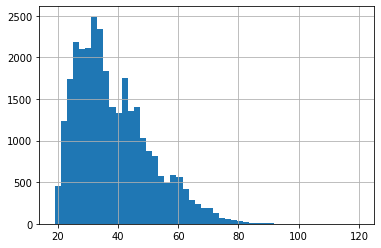

In [108]:
metadata['Age'].hist(bins=50)

In [109]:
metadata["Age"].describe()

count    30404.000000
mean        38.855677
std         12.300827
min         19.000000
25%         29.000000
50%         36.000000
75%         46.000000
max        120.000000
Name: Age, dtype: float64

In [110]:
# Filled the missing value for Age with the median value of the distribution
median_age = 36.0
metadata['Age'].fillna(value= median_age, inplace=True)

In [111]:
metadata["Age"].isnull().sum()

0

#### REGION

In [112]:
metadata['Region'].value_counts()

Nyanza                6998
North Rift            5344
Nairobi Region        5056
South Rift            4759
Coast Region          4671
Western               4508
Mount Kenya Region    4073
Name: Region, dtype: int64

In [113]:
#Filled the missing values as unknown regions

metadata['Region'].fillna(value='Unknown', inplace=True)

#### UPSELL  
The missing values in UpsellDate is over 90%, as such, rather than filling it, we create a new feature to capture the Upsell, and drop the UpsellDate feature.

In [114]:
metadata['Upsell_or_not'] = np.where(metadata['UpsellDate'].notnull(), 1, 0)

In [115]:
metadata.head()

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,Upsell_or_not
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,0
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,0
2,ID_102CV85,2015-12-18 00:00:00,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,1
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,Unknown,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,0
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,0


In [116]:
metadata.drop('UpsellDate', axis=1, inplace=True)

In [117]:
metadata.isnull().any().any()

False

## Extracting Features

### Creating features for the sum and average of all payments.

In [118]:
train['PayHist_avg'] = 0
train['Sum_of_Payments'] = 0
for i in range(len(train)):
    train['PayHist_avg'][i]= np.mean(eval(train['PaymentsHistory'][i]))
    train['Sum_of_Payments'][i] = np.sum(eval(train['PaymentsHistory'][i]))
    train['PaymentsHistory'][i] = eval(train['PaymentsHistory'][i])
    
test['PayHist_avg'] = 0   
test['Sum_of_Payments'] = 0
for i in range(len(test)):
    test['PayHist_avg'][i]= np.mean(eval(test['PaymentsHistory'][i]))
    test['Sum_of_Payments'][i] = np.sum(eval(test['PaymentsHistory'][i]))
    test['PaymentsHistory'][i] = eval(test['PaymentsHistory'][i])

_Collecting the metadata of train and test for all instances_

In [120]:
merged_train = pd.merge(left=metadata, right=train, on="ID")

In [121]:
merged_train.shape

(28007, 29)

In [122]:
merged_test = pd.merge(left=metadata, right=test, on="ID")

In [123]:
merged_train.head(n=5)

,ID,RegistrationDate,Deposit,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,Upsell_or_not,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,PayHist_avg,Sum_of_Payments
0,ID_K00S4N4,2015-12-10 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,0,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3050.0, 1050.0, 910.0, 1050.0, 1050.0]",1225.0,1050.0,1190.0,525.0,1750.0,1890.0,1422,7110
1,ID_102CV85,2015-12-18 00:00:00,2000,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,1,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4245.0, 980.0, 735.0, 735.0, 1470.0, 735.0, 9...",980.0,980.0,1225.0,980.0,935.0,355.0,1281,11530
2,ID_HXBJFHB,2015-11-25 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Female,43.0,Unknown,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,0,"['11-2015', '12-2015', '01-2016', '02-2016', '...","[2245.0, 980.0, 980.0, 1225.0, 980.0, 980.0, 9...",250.0,1000.0,250.0,500.0,560.0,1150.0,1006,11070
3,ID_3K9VZ5J,2015-12-02 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,0,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[2750.0, 1000.0, 750.0, 1000.0, 955.0, 880.0, ...",630.0,805.0,700.0,855.0,245.0,775.0,894,10730
4,ID_6YU5YRB,2015-12-10 00:00:00,2000,0.0,FINANCED,DAILY,35,7,Male,56.0,Mount Kenya Region,Meru,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 15:15:16,0,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3010.0, 665.0, 1035.0, 985.0, 1020.0, 1120.0,...",1050.0,985.0,1085.0,980.0,1770.0,90.0,1254,8780


### _Further Exploration and Creation of Features_

In [125]:
merged_train[['TotalContractValue', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'Sum_of_Payments', 'Upsell_or_not']]

,TotalContractValue,m1,m2,m3,m4,m5,m6,Sum_of_Payments,Upsell_or_not
0,14740.0,1225.0,1050.0,1190.0,525.0,1750.0,1890.0,7110,0
1,29480.0,980.0,980.0,1225.0,980.0,935.0,355.0,11530,1
2,14740.0,250.0,1000.0,250.0,500.0,560.0,1150.0,11070,0
3,14740.0,630.0,805.0,700.0,855.0,245.0,775.0,10730,0
4,14740.0,1050.0,985.0,1085.0,980.0,1770.0,90.0,8780,0
...,...,...,...,...,...,...,...,...,...
28002,14400.0,1300.0,650.0,950.0,1450.0,1500.0,900.0,7650,0
28003,14400.0,1150.0,850.0,100.0,50.0,1200.0,50.0,9500,0
28004,16600.0,1040.0,640.0,800.0,840.0,1120.0,840.0,11320,0
28005,14400.0,500.0,850.0,650.0,700.0,600.0,700.0,8440,0


In [126]:
merged_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Deposit,28007.0,2348.559432,418.987356,0.0,2000.0,2000.0,2500.0,8000.0
AccessoryRate,28007.0,1.164138,7.985585,0.0,0.0,0.0,0.0,240.0
RatePerUnit,28007.0,49.784768,58.142391,35.0,40.0,40.0,55.0,4000.0
DaysOnDeposit,28007.0,4.592566,3.336599,0.0,3.0,3.0,7.0,60.0
Age,28007.0,38.383404,11.194745,19.0,31.0,36.0,44.0,120.0
Term,28007.0,412.400864,121.495244,10.0,364.0,364.0,547.0,626.0
TotalContractValue,28007.0,22962.232763,10166.829070,10800.0,16560.0,16560.0,33080.0,64484.0
Upsell_or_not,28007.0,0.026493,0.160600,0.0,0.0,0.0,0.0,1.0
m1,28007.0,815.411683,686.130805,1.0,275.0,820.0,1200.0,33890.0
m2,28007.0,807.101617,839.772177,1.0,250.0,800.0,1200.0,94044.0


In [127]:
merged_train['PaymentsHistory'].value_counts()

[3500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]                                                                                                                                                                               37
[3200.0, 1200.0, 1200.0, 1200.0, 1200.0, 1200.0, 1200.0]                                                                                                                                                                               33
[3200.0, 1200.0, 1200.0, 1200.0, 1200.0, 1200.0]                                                                                                                                                                                       21
[3200.0, 1200.0, 1200.0, 1200.0, 1200.0]                                                                                                                                                                                                9
[3500.0, 1000.0, 2000.0, 1000.0, 1000.0, 1000.0]                

In [128]:
merged_train['TransactionDates'].value_counts()

['01-2020', '02-2020', '03-2020', '04-2020', '05-2020']                                                                                                                                                                                                                                                                                                                                              941
['01-2020', '02-2020', '03-2020', '04-2020', '05-2020', '06-2020']                                                                                                                                                                                                                                                                                                                                   692
['01-2020', '02-2020', '03-2020', '04-2020', '05-2020', '06-2020', '07-2020', '08-2020', '09-2020', '10-2020', '11-2020']                                                                                             

 _**The result shows that we are predicting next six month payment of different dates for different customers**_

In [129]:
merged_train[['PaymentsHistory', 'TransactionDates', 'FirstPaymentDate', 'ExpectedTermDate']]

,PaymentsHistory,TransactionDates,FirstPaymentDate,ExpectedTermDate
0,"[3050.0, 1050.0, 910.0, 1050.0, 1050.0]","['12-2015', '01-2016', '02-2016', '03-2016', '...",2015-12-10 09:52:35,2016-12-08 00:00:00
1,"[4245.0, 980.0, 735.0, 735.0, 1470.0, 735.0, 9...","['12-2015', '01-2016', '02-2016', '03-2016', '...",2015-12-18 06:22:34,2017-01-13 00:00:00
2,"[2245.0, 980.0, 980.0, 1225.0, 980.0, 980.0, 9...","['11-2015', '12-2015', '01-2016', '02-2016', '...",2015-11-25 13:25:57,2016-11-23 00:00:00
3,"[2750.0, 1000.0, 750.0, 1000.0, 955.0, 880.0, ...","['12-2015', '01-2016', '02-2016', '03-2016', '...",2015-12-05 10:34:32,2016-11-30 00:00:00
4,"[3010.0, 665.0, 1035.0, 985.0, 1020.0, 1120.0,...","['12-2015', '01-2016', '02-2016', '03-2016', '...",2015-12-10 15:15:16,2016-12-08 00:00:00
...,...,...,...,...
28002,"[2680.0, 1240.0, 1230.0, 1100.0, 1400.0]","['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 18:26:58,2020-10-17 18:26:52
28003,"[2700.0, 400.0, 950.0, 1150.0, 1150.0, 750.0, ...","['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 18:31:06,2020-10-17 18:30:59
28004,"[3680.0, 600.0, 920.0, 920.0, 920.0, 1240.0, 1...","['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 18:42:33,2021-01-25 18:42:26
28005,"[2620.0, 1300.0, 1200.0, 1050.0, 1100.0, 650.0...","['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 18:46:37,2020-10-17 18:46:30


_**First TransactionDates month and year corresponds with the FirstPaymentDate month and year**_

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


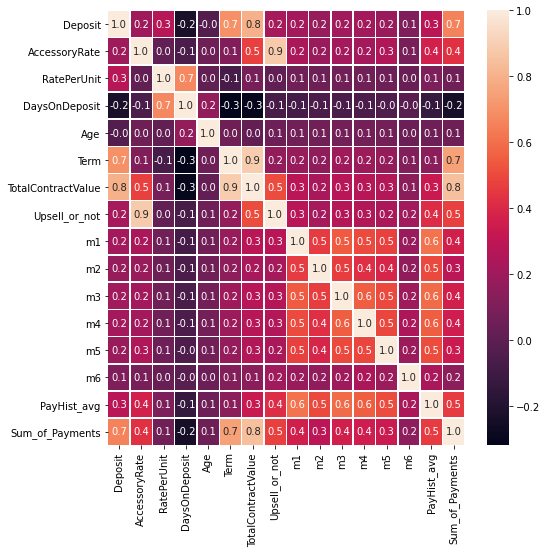

In [131]:
f,ax=plt.subplots(figsize=(8,8))
sn.heatmap(merged_train.corr(),annot=True,linewidth=.5,fmt='.1f',ax=ax)
plt.show()

#### RECENT PAYMENTS   
_**We place the first 4 recent payments out to reflect present condition**_

In [132]:
merged_train['Recent_Pay1'] = 0
merged_train['Recent_Pay2'] = 0
merged_train['Recent_Pay3'] = 0
merged_train['Recent_Pay4'] = 0
for i in range(len(train)):
    merged_train['Recent_Pay1'][i]= merged_train['PaymentsHistory'][i][-1]
    merged_train['Recent_Pay2'][i]= merged_train['PaymentsHistory'][i][-2]
    merged_train['Recent_Pay3'][i]= merged_train['PaymentsHistory'][i][-3]
    merged_train['Recent_Pay4'][i]= merged_train['PaymentsHistory'][i][-4]
    
    
merged_test['Recent_Pay1'] = 0
merged_test['Recent_Pay2'] = 0
merged_test['Recent_Pay3'] = 0
merged_test['Recent_Pay4'] = 0
for i in range(len(test)):
    merged_test['Recent_Pay1'][i]= merged_test['PaymentsHistory'][i][-1]
    merged_test['Recent_Pay2'][i]= merged_test['PaymentsHistory'][i][-2]
    merged_test['Recent_Pay3'][i]= merged_test['PaymentsHistory'][i][-3]
    merged_test['Recent_Pay4'][i]= merged_test['PaymentsHistory'][i][-4]
    

#### NUMBER OF PAYMENTS  
_**A feature to capture the number of payments made per instance**_

In [133]:
merged_train['PaymentHistory_length'] = 0
for i in range(len(merged_train)):
    merged_train['PaymentHistory_length'][i] = len(merged_train['PaymentsHistory'][i])
    
    
    

merged_test['PaymentHistory_length'] = 0
for i in range(len(merged_test)):
    merged_test['PaymentHistory_length'][i] = len(merged_test['PaymentsHistory'][i])

### Junction! 

_We create a copy of the merged train and test data to avoid reverting back for any slight mistake_

In [135]:
train_set = merged_train.copy()
test_set = merged_test.copy()

### Date-time features

In [136]:
date_cols = ['RegistrationDate', 'ExpectedTermDate', 'FirstPaymentDate']
for feat in date_cols:
    train_set[feat]=pd.to_datetime(train_set[feat])
        

In [137]:
date_cols = ['RegistrationDate', 'ExpectedTermDate', 'FirstPaymentDate']
for feat in date_cols:
    test_set[feat]=pd.to_datetime(test_set[feat], infer_datetime_format=True, errors='coerce')
        

In [138]:
datetime_cols = ['FirstPaymentDate',  'ExpectedTermDate']
def extract_date_info(df,cols,):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.year
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat+'_WeekDay'] = df[feat].dt.weekday
        df[feat+'_Quarter'] = df[feat].dt.quarter
    df.drop(columns=cols,axis=1,inplace=True)
    
extract_date_info(train_set, datetime_cols)    

In [139]:
extract_date_info(test_set, datetime_cols)

### _Feature Extraction_

In [141]:
# The expected cumulative target payment to be made and the payment_ratio based on TotalContractValue
train_set['expected_m1-m6_payment'] = train_set['TotalContractValue'] - train_set['Sum_of_Payments']
train_set['payment_ratio'] = (train_set['Sum_of_Payments']/train_set['TotalContractValue'])*100


# the viability of complete payment (with a threshold of 60%), and the average (monthly) expected payment per instance
train_set['good_or_bad_viability'] = np.where(train_set['payment_ratio']> 60, 1, 0)
train_set['average_monthly_expected_payment'] = train_set['expected_m1-m6_payment']/n_months

## the same for the test set
test_set['expected_m1-m6_payment'] = test_set['TotalContractValue'] - test_set['Sum_of_Payments']
test_set['payment_ratio'] = (test_set['Sum_of_Payments']/test_set['TotalContractValue'])*100
test_set['good_or_bad_viability'] = np.where(test_set['payment_ratio']> 60, 1, 0)
test_set['average_monthly_expected_payment'] = test_set['expected_m1-m6_payment']/n_months

### _Creating features comprising the most recent TransactionDates Month and Year_

In [142]:
train_set['LastTransactionDatesMonth'] = 0
train_set['LastTransactionDatesYear'] = 0
for i in range(len(train_set)):
    train_set['LastTransactionDatesMonth'][i] = (train_set['TransactionDates'][i][-9:-7])
    train_set['LastTransactionDatesYear'][i] = (train_set['TransactionDates'][i][-6:-2])

In [143]:
test_set['LastTransactionDatesMonth'] = 0
test_set['LastTransactionDatesYear'] = 0
for i in range(len(test_set)):
    test_set['LastTransactionDatesMonth'][i] = (test_set['TransactionDates'][i][-9:-7])
    test_set['LastTransactionDatesYear'][i] = (test_set['TransactionDates'][i][-6:-2])

### _Lateness Capture_  

_**The last Transaction date per instance should be earlier than the expected term date or at most be the same date.**_  
_**This feature captues instances with last Transaction dates later than the expected term date**_  

_**Because we have just the month and year of the last transaction date, the lateness capture reflects a monthly instance of lateness**_

In [144]:
train_set['lateness_capture'] = 0
for i in range(len(train_set)):
    tr_month = (train_set['LastTransactionDatesYear'][i])*12 + train_set['LastTransactionDatesMonth'][i]
    ex_month = (train_set['ExpectedTermDate_year'][i])*12 + train_set['ExpectedTermDate_month'][i]
    train_set['lateness_capture'][i] = ex_month-tr_month

In [145]:
test_set['lateness_capture'] = 0
for i in range(len(test_set)):
    tr_month = (test_set['LastTransactionDatesYear'][i])*12 + test_set['LastTransactionDatesMonth'][i]
    ex_month = (test_set['ExpectedTermDate_year'][i])*12 + test_set['ExpectedTermDate_month'][i]
    test_set['lateness_capture'][i] = ex_month-tr_month

### _Since we are trying to build a model that predicts the payment for n_months, any instance with lateness capture less than n_months(6) will take more than the expected time to complete the payment_

In [146]:
train_set['early_or_late_m1_to_m6'] = np.where(train_set['lateness_capture']>=n_months, 1, 0)

test_set['early_or_late_m1_to_m6'] = np.where(test_set['lateness_capture']>=n_months, 1, 0)

### _Further Exploration_

In [147]:
train_set[['AccessoryRate','Upsell_or_not']]

,AccessoryRate,Upsell_or_not
0,0.0,0
1,35.0,1
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
28002,0.0,0
28003,0.0,0
28004,0.0,0
28005,0.0,0


In [148]:
train_set['Upsell_or_not'].value_counts()

0    27265
1      742
Name: Upsell_or_not, dtype: int64

_**Approximately 3% of instances got an upsell from SFC**_

In [149]:
train_set[['expected_m1-m6_payment', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'Term', 'Upsell_or_not']]

,expected_m1-m6_payment,m1,m2,m3,m4,m5,m6,Term,Upsell_or_not
0,7630.0,1225.0,1050.0,1190.0,525.0,1750.0,1890.0,364,0
1,17950.0,980.0,980.0,1225.0,980.0,935.0,355.0,392,1
2,3670.0,250.0,1000.0,250.0,500.0,560.0,1150.0,364,0
3,4010.0,630.0,805.0,700.0,855.0,245.0,775.0,364,0
4,5960.0,1050.0,985.0,1085.0,980.0,1770.0,90.0,364,0
...,...,...,...,...,...,...,...,...,...
28002,6750.0,1300.0,650.0,950.0,1450.0,1500.0,900.0,240,0
28003,4900.0,1150.0,850.0,100.0,50.0,1200.0,50.0,240,0
28004,5280.0,1040.0,640.0,800.0,840.0,1120.0,840.0,340,0
28005,5960.0,500.0,850.0,650.0,700.0,600.0,700.0,240,0


_**The labeled expected_m1-m6_payment also includes upsell price for upsell**_ 

### _Simulating the Upsell Amount_

In [150]:
train_set[train_set['Upsell_or_not']==0][['TotalContractValue', 'RatePerUnit','Sum_of_Payments', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'AccessoryRate']]

,TotalContractValue,RatePerUnit,Sum_of_Payments,m1,m2,m3,m4,m5,m6,AccessoryRate
0,14740.0,35,7110,1225.0,1050.0,1190.0,525.0,1750.0,1890.0,0.0
2,14740.0,35,11070,250.0,1000.0,250.0,500.0,560.0,1150.0,0.0
3,14740.0,35,10730,630.0,805.0,700.0,855.0,245.0,775.0,0.0
4,14740.0,35,8780,1050.0,985.0,1085.0,980.0,1770.0,90.0,0.0
5,14740.0,35,12000,855.0,675.0,1015.0,950.0,920.0,325.0,0.0
...,...,...,...,...,...,...,...,...,...,...
28002,14400.0,50,7650,1300.0,650.0,950.0,1450.0,1500.0,900.0,0.0
28003,14400.0,50,9500,1150.0,850.0,100.0,50.0,1200.0,50.0,0.0
28004,16600.0,40,11320,1040.0,640.0,800.0,840.0,1120.0,840.0,0.0
28005,14400.0,50,8440,500.0,850.0,650.0,700.0,600.0,700.0,0.0


In [151]:
train_set[train_set['Upsell_or_not']==1][['TotalContractValue', 'RatePerUnit', 'Sum_of_Payments', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'AccessoryRate']]

,TotalContractValue,RatePerUnit,Sum_of_Payments,m1,m2,m3,m4,m5,m6,AccessoryRate
1,29480.0,35,11530,980.0,980.0,1225.0,980.0,935.0,355.0,35.0
54,18560.0,40,15560,120.0,90.0,100.0,220.0,180.0,190.0,20.0
59,18560.0,40,17260,100.0,240.0,100.0,280.0,300.0,360.0,20.0
61,18060.0,40,17340,285.0,200.0,40.0,80.0,40.0,40.0,30.0
63,34120.0,40,12350,700.0,990.0,679.0,580.0,739.0,1022.0,40.0
...,...,...,...,...,...,...,...,...,...,...
21173,56964.0,55,41698,2500.0,2400.0,2766.0,2580.0,2800.0,2220.0,40.0
21199,56964.0,55,44377,1589.0,1750.0,2900.0,2665.0,2755.0,928.0,40.0
21269,56964.0,55,44984,155.0,485.0,400.0,1638.0,289.0,1140.0,40.0
21270,56964.0,55,42890,2100.0,2400.0,1900.0,2500.0,1900.0,3274.0,40.0


In [152]:
train_set['RatePerUnit'].unique()

array([  35,   40, 1000,   50,   55,   95, 4000,   90,   67,  280,   85],
      dtype=int64)

In [153]:
train_set.groupby('RatePerUnit')[['Upsell_or_not', 'TotalContractValue']].describe()

Upsell_or_not                                               \
                    count      mean       std  min  25%  50%  75%  max   
RatePerUnit                                                              
35                   66.0  0.015152  0.123091  0.0  0.0  0.0  0.0  1.0   
40                14512.0  0.001585  0.039781  0.0  0.0  0.0  0.0  1.0   
50                 2104.0  0.001901  0.043571  0.0  0.0  0.0  0.0  1.0   
55                11140.0  0.064093  0.244930  0.0  0.0  0.0  0.0  1.0   
67                   31.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
85                   25.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
90                    1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0   
95                    4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
280                  57.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
1000                 65.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
4000                  2.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

            TotalContractValue                                               \
                         count          mean          std      min      25%   
RatePerUnit                                                                   
35                        66.0  14963.333333  1814.368577  14740.0  14740.0   
40                     14512.0  15448.656284  1770.243000  10800.0  12800.0   
50                      2104.0  14473.441065  1691.921940  14000.0  14400.0   
55                     11140.0  34515.178815  5692.576520  33080.0  33080.0   
67                        31.0  12000.000000     0.000000  12000.0  12000.0   
85                        25.0  19575.000000     0.000000  19575.0  19575.0   
90                         1.0  51230.000000          NaN  51230.0  51230.0   
95                         4.0  56964.000000     0.000000  56964.0  56964.0   
280                       57.0  12800.000000     0.000000  12800.0  12800.0   
1000                      65.0  15500.000000     0.000000  15500.0  15500.0   
4000                       2.0  48000.000000     0.000000  48000.0  48000.0   

                                        
                 50%      75%      max  
RatePerUnit                             
35           14740.0  14740.0  29480.0  
40           16560.0  16560.0  34120.0  
50           14400.0  14400.0  53230.0  
55           33084.0  33084.0  64484.0  
67           12000.0  12000.0  12000.0  
85           19575.0  19575.0  19575.0  
90           51230.0  51230.0  51230.0  
95           56964.0  56964.0  56964.0  
280          12800.0  12800.0  12800.0  
1000         15500.0  15500.0  15500.0  
4000         48000.0  48000.0  48000.0

### _Link for Simulating The Upsell Bill: RatePerUnit_

__*Upsell bills were purchased for 35, 40, 50 and 55 RatePerUnit services(products)*__  


__*Taking the difference between the maximum value of TotalContractValue(upsell bill included) and median value(assumed original bill without upsell), we get the upsell price attached for instances with Upsell.*__  

In [154]:
upsell_bill_mapper = {35: 14740, 40: 16560, 50: 14400, 55:33084, 67:12000, 85:19575, 90: 51230, 95:56964, 280:12800, 1000:15500, 4000:48000}

In [155]:
train_set['upsell_bill'] = (train_set['TotalContractValue']) - (train_set['RatePerUnit'].map(upsell_bill_mapper))

In [156]:
#To correct for any irregularities
train_set['upsell_bill'] = np.where(train_set['upsell_bill']<=0, 0, train_set['upsell_bill'])

In [157]:
test_set['upsell_bill'] = (test_set['TotalContractValue']) - (test_set['RatePerUnit'].map(upsell_bill_mapper))

test_set['upsell_bill'] = np.where(test_set['upsell_bill']<=0, 0, test_set['upsell_bill'])

### _Upsell_TotalContract_ratio_

In [158]:
train_set['TotalContract_Upsell_bill_ratio'] = 100 * (train_set['upsell_bill']/train_set['TotalContractValue'])


test_set['TotalContract_Upsell_bill_ratio'] = 100 * (test_set['upsell_bill']/test_set['TotalContractValue'])

### _Dropping Features:_

In [159]:
train_set.drop(['SupplierName', 'RegistrationDate', 
               'PaymentMethod','TransactionDates', 
                'PaymentsHistory'], axis=1, inplace=True)

test_set.drop(['SupplierName', 'RegistrationDate', \
              'PaymentMethod', 'TransactionDates', \
               'PaymentsHistory'], axis=1, inplace=True)


In [160]:
train_set.head()

,ID,Deposit,AccessoryRate,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,Term,TotalContractValue,Upsell_or_not,m1,m2,m3,m4,m5,m6,PayHist_avg,Sum_of_Payments,Recent_Pay1,Recent_Pay2,Recent_Pay3,Recent_Pay4,PaymentHistory_length,FirstPaymentDate_year,FirstPaymentDate_day,FirstPaymentDate_month,FirstPaymentDate_WeekDay,FirstPaymentDate_Quarter,ExpectedTermDate_year,ExpectedTermDate_day,ExpectedTermDate_month,ExpectedTermDate_WeekDay,ExpectedTermDate_Quarter,expected_m1-m6_payment,payment_ratio,good_or_bad_viability,average_monthly_expected_payment,LastTransactionDatesMonth,LastTransactionDatesYear,lateness_capture,early_or_late_m1_to_m6,upsell_bill,TotalContract_Upsell_bill_ratio
0,ID_K00S4N4,2000,0.0,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,364,14740.0,0,1225.0,1050.0,1190.0,525.0,1750.0,1890.0,1422,7110,1050,1050,910,1050,5,2015,10,12,3,4,2016,8,12,3,4,7630.0,48.236092,0,1271.666667,4,2016,8,1,0.0,0.0
1,ID_102CV85,2000,35.0,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,392,29480.0,1,980.0,980.0,1225.0,980.0,935.0,355.0,1281,11530,735,915,980,735,9,2015,18,12,4,4,2017,13,1,4,1,17950.0,39.111262,0,2991.666667,8,2016,5,0,14740.0,50.0
2,ID_HXBJFHB,2000,0.0,DAILY,35,7,Female,43.0,Unknown,UNKNOWN,Teacher,364,14740.0,0,250.0,1000.0,250.0,500.0,560.0,1150.0,1006,11070,250,490,735,1225,11,2015,25,11,2,4,2016,23,11,2,4,3670.0,75.101764,1,611.666667,10,2016,1,0,0.0,0.0
3,ID_3K9VZ5J,2000,0.0,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,364,14740.0,0,630.0,805.0,700.0,855.0,245.0,775.0,894,10730,735,525,420,770,12,2015,5,12,5,4,2016,30,11,2,4,4010.0,72.795115,1,668.333333,11,2016,0,0,0.0,0.0
4,ID_6YU5YRB,2000,0.0,DAILY,35,7,Male,56.0,Mount Kenya Region,Meru,Other,364,14740.0,0,1050.0,985.0,1085.0,980.0,1770.0,90.0,1254,8780,945,1120,1020,985,7,2015,10,12,3,4,2016,8,12,3,4,5960.0,59.565807,0,993.333333,6,2016,6,1,0.0,0.0


In [161]:
print(train_set.shape)
print(test_set.shape)

(28007, 47)
(9336, 41)


### _Categorical Columns_

In [162]:
cat_col = ['Occupation', 'Region', 'MainApplicantGender', 'rateTypeEntity']
df = train_set

def check_categorical_relationship(cat_col,df):
    for feat in cat_col:
        plt.figure(figsize=(12,5))
        sn.countplot(df[feat])
        plt.show()
        print("\n \n \n ")

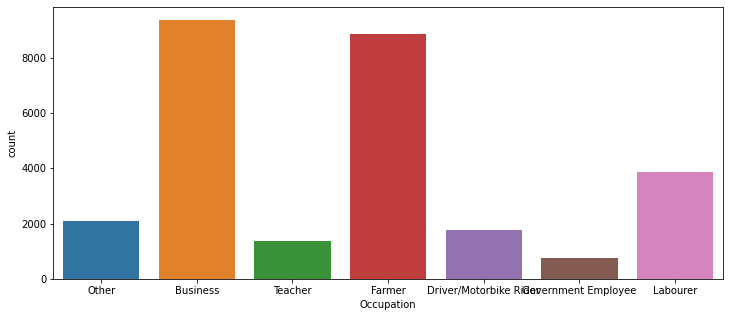

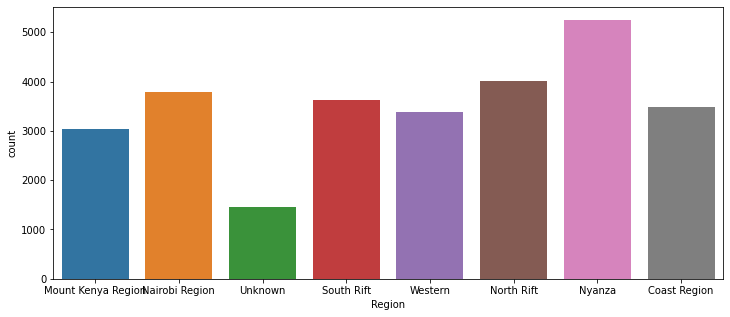

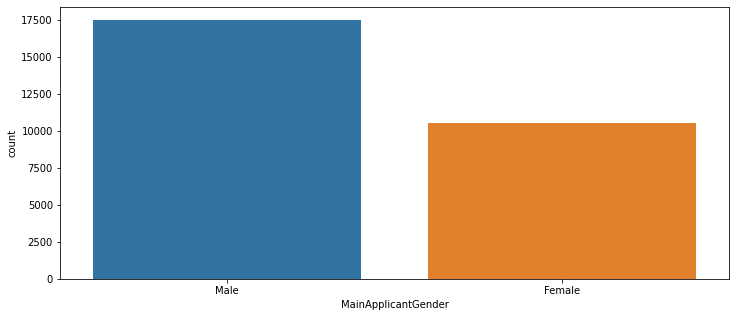

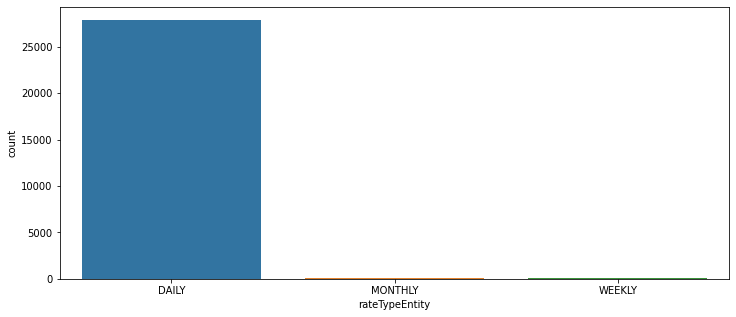

In [163]:
check_categorical_relationship(cat_col, df)

In [164]:
print(train_set.shape)
print(test_set.shape)

(28007, 47)
(9336, 41)


_Getting a feel of the skewness of my data_

In [165]:
train_set.skew()

Deposit                              0.593342
AccessoryRate                        9.095669
RatePerUnit                         32.653285
DaysOnDeposit                       11.030040
Age                                  1.127100
Term                                -0.046165
TotalContractValue                   0.984897
Upsell_or_not                        5.897137
m1                                  10.708185
m2                                  49.739251
m3                                   9.059452
m4                                   9.035916
m5                                  22.023699
m6                                  24.328596
PayHist_avg                          1.813530
Sum_of_Payments                      1.213419
Recent_Pay1                         11.998577
Recent_Pay2                          6.053194
Recent_Pay3                          3.205955
Recent_Pay4                         26.503244
PaymentHistory_length                0.653433
FirstPaymentDate_year             

In [166]:
test_set.skew()

Deposit                              0.551104
AccessoryRate                        7.645490
RatePerUnit                         16.233640
DaysOnDeposit                       10.887739
Age                                  1.167930
Term                                -0.069863
TotalContractValue                   0.950185
Upsell_or_not                        6.119885
PayHist_avg                          1.282140
Sum_of_Payments                      1.292259
Recent_Pay1                          1.571660
Recent_Pay2                          0.962526
Recent_Pay3                          0.702155
Recent_Pay4                         40.622011
PaymentHistory_length                0.631305
FirstPaymentDate_year                0.638271
FirstPaymentDate_day                 0.011950
FirstPaymentDate_month               0.718660
FirstPaymentDate_WeekDay             0.079891
FirstPaymentDate_Quarter             0.641543
ExpectedTermDate_year               -0.009920
ExpectedTermDate_day              

### Junction!

_Pre-Modeling_

In [169]:
y = train_set[['m1', 'm2', 'm3', 'm4', 'm5', 'm6']]
X = train_set.drop(['m1', 'm2', 'm3', 'm4', 'm5', 'm6'], axis=1)

In [170]:
X.shape

(28007, 41)

In [171]:
# join train and test together
ntrain = X.shape[0]
ntest = test_set.shape[0]

all_data = pd.concat((X, test_set)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (37343, 41)


In [172]:
cat_col = ['Occupation', 'Region', 'MainApplicantGender', 'rateTypeEntity', 'Town']

In [173]:
all_data = pd.get_dummies(data = all_data, columns = cat_col, drop_first=True)

In [174]:
cat = ['ID']
for i in cat:
  encoder = LabelEncoder()
  all_data[i] = encoder.fit_transform(all_data[i])

_**Label-Encoded the 'ID' feature, and used a dummie for all other categorical features**_

In [175]:
#Get the new dataset
X = all_data[:ntrain]
test_final = all_data[ntrain:]

In [176]:
X.to_csv('SFC_PAYGo/train_final.csv', index=False)
test_final.to_csv('SFC_PAYGo/test_final.csv', index=False)
y.to_csv('SFC_PAYGo/target.csv', index=False)

## Pre - Modeling

In [177]:
X = pd.read_csv('SFC_PAYGo/train_final.csv')
test_final = pd.read_csv('SFC_PAYGo/test_final.csv')
y = pd.read_csv('SFC_PAYGo/target.csv')

In [178]:
print(X.shape)
print(test_final.shape)
print(y.shape)

(28007, 99)
(9336, 99)
(28007, 6)


In [179]:
X.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Term,TotalContractValue,Upsell_or_not,PayHist_avg,Sum_of_Payments,Recent_Pay1,Recent_Pay2,Recent_Pay3,Recent_Pay4,PaymentHistory_length,FirstPaymentDate_year,FirstPaymentDate_day,FirstPaymentDate_month,FirstPaymentDate_WeekDay,FirstPaymentDate_Quarter,ExpectedTermDate_year,ExpectedTermDate_day,ExpectedTermDate_month,ExpectedTermDate_WeekDay,ExpectedTermDate_Quarter,expected_m1-m6_payment,payment_ratio,good_or_bad_viability,average_monthly_expected_payment,LastTransactionDatesMonth,LastTransactionDatesYear,lateness_capture,early_or_late_m1_to_m6,upsell_bill,TotalContract_Upsell_bill_ratio,Occupation_Driver/Motorbike Rider,Occupation_Farmer,Occupation_Government Employee,Occupation_Labourer,Occupation_Other,Occupation_Teacher,Region_Mount Kenya Region,Region_Nairobi Region,Region_North Rift,Region_Nyanza,Region_South Rift,Region_Unknown,Region_Western,MainApplicantGender_Male,rateTypeEntity_MONTHLY,rateTypeEntity_WEEKLY,Town_Bomet,Town_Bungoma,Town_Busia,Town_Elgeyo/Marakwet,Town_Embu,Town_Garissa,Town_Homa Bay,Town_Isiolo,Town_Kajiado,Town_Kakamega,Town_Kericho,Town_Kiambu,Town_Kilifi,Town_Kirinyaga,Town_Kisii,Town_Kisumu,Town_Kitui,Town_Kwale,Town_Laikipia,Town_Lamu,Town_Machakos,Town_Makueni,Town_Mandera,Town_Marsabit,Town_Meru,Town_Migori,Town_Mombasa,Town_Muranga,Town_Nairobi City,Town_Nakuru,Town_Nandi,Town_Narok,Town_Nyamira,Town_Nyandarua,Town_Nyeri,Town_Samburu,Town_Siaya,Town_Taita/Taveta,Town_Tana River,Town_Tharaka-Nithi,Town_Trans Nzoia,Town_Turkana,Town_UNKNOWN,Town_Uasin Gishu,Town_Vihiga,Town_Wajir,Town_West Pokot
0,20744,2000,0.0,35,7,41.0,364,14740.0,0,1422,7110,1050,1050,910,1050,5,2015,10,12,3,4,2016,8,12,3,4,7630.0,48.236092,0,1271.666667,4,2016,8,1,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1028,2000,35.0,35,7,48.0,392,29480.0,1,1281,11530,735,915,980,735,9,2015,18,12,4,4,2017,13,1,4,1,17950.0,39.111262,0,2991.666667,8,2016,5,0,14740.0,50.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,18628,2000,0.0,35,7,43.0,364,14740.0,0,1006,11070,250,490,735,1225,11,2015,25,11,2,4,2016,23,11,2,4,3670.0,75.101764,1,611.666667,10,2016,1,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3680,2000,0.0,35,7,56.0,364,14740.0,0,894,10730,735,525,420,770,12,2015,5,12,5,4,2016,30,11,2,4,4010.0,72.795115,1,668.333333,11,2016,0,0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7248,2000,0.0,35,7,56.0,364,14740.0,0,1254,8780,945,1120,1020,985,7,2015,10,12,3,4,2016,8,12,3,4,5960.0,59.565807,0,993.333333,6,2016,6,1,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [180]:
# Numpy array
X_test = np.array(test_final)
X = np.array(X)
y = np.array(y)

In [181]:
y

array([[1225., 1050., 1190.,  525., 1750., 1890.],
       [ 980.,  980., 1225.,  980.,  935.,  355.],
       [ 250., 1000.,  250.,  500.,  560., 1150.],
       ...,
       [1040.,  640.,  800.,  840., 1120.,  840.],
       [ 500.,  850.,  650.,  700.,  600.,  700.],
       [1450.,  800.,  250.,   50.,  150.,  650.]])

In [182]:
kfold=KFold(n_splits=10, random_state=12, shuffle =True)

# _ML - Modeling:_ 

_The final submission was formed from a stack of 8 models, with an ExtraTree Regressor as a meta estimator_.


### _EXTRATREE MODEL_

In [186]:
et_reg = ExtraTreesRegressor(max_depth=12, max_features='auto', 
                             min_samples_split=8, min_weight_fraction_leaf=0.0,
                             n_estimators=600, random_state=12, criterion='mse')

In [187]:
def et_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = []
    val_pred = np.empty((len(train), 6))
    for count, (train_index,test_index) in enumerate(kfold.split(train,label)):
        x_train,x_test = train[train_index], train[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        print(f'========================Fold{count +1}==========================')
        
        estimator.fit(x_train,y_train)
        train_predict = estimator.predict(x_train)
        test_predict = estimator.predict(x_test)
        val_pred[test_index] = (test_predict)
        f_test= (estimator.predict(test))
        test_pred.append(f_test)
        print('\nValidation scores', np.sqrt(mean_squared_error(y_test, test_predict)))
        print('\nTraining scores', np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_test_val.append(np.sqrt(mean_squared_error(y_test,test_predict)))
    print('Average Testing RMSE score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training RMSE score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

In [188]:
et_val, et_test, et_estimator = et_predict(et_reg, X, y, X_test, 'et_reg')

========================Fold1==========================

Validation scores 572.7706482402772

Training scores 450.1224005109009
========================Fold2==========================

Validation scores 587.5400307377962

Training scores 443.8124126806475
========================Fold3==========================

Validation scores 1067.4436155945475

Training scores 444.1840418127261
========================Fold4==========================

Validation scores 784.0635952510685

Training scores 436.77993664308184
========================Fold5==========================

Validation scores 530.7621926105867

Training scores 446.35167202427266
========================Fold6==========================

Validation scores 796.6492221803032

Training scores 425.3576560552575
========================Fold7==========================

Validation scores 603.1536727734272

Training scores 439.9771125738604
========================Fold8==========================

Validation scores 1023.9348294631793

Traini

In [189]:
et_test = np.mean(et_test, axis=0)
pred = et_test.reshape(-1, 1)

In [191]:
ss["Target"] = pred

In [192]:
pd.DataFrame(et_test).to_csv('SFC_PAYGo/et_test2.csv', index=False)
pd.DataFrame(et_val).to_csv('SFC_PAYGo/et_val2.csv', index=False)
ss.to_csv('SFC_PAYGo/extratree.csv', index=False)

_The submission **extratree** was made on the 26th of August, during the competition, and has a private leaderboard score of 672.704_  
_**A score higher than  that of my final prediction on the leaderboard.**_

## _To the other models:_

### _LGB Model_

In [193]:
#Gradient boosting models do not perform multiple regressor output
#The sklearn wrapper: RegressorChain was used instead of the MultiOutPut Regressor 
#because the predictions are dependent on each other

lgb_reg = LGBMRegressor(bagging_freq=7, colsample_bytree=0.6596461695321297,
              lambda_l1=0.6548430294792729, lambda_l2=2.935128235687181,
              learning_rate=0.026200647230093844, max_bin=79, max_depth=5,
              metric='rmse', min_child_samples=70, n_estimators=1000,
              num_leaves=67, objective='regression', random_state=12,
              subsample=0.9084107983828029)



lgb_model = RegressorChain(lgb_reg, random_state=12) 



In [194]:
lgb_model

RegressorChain(base_estimator=LGBMRegressor(bagging_freq=7,
                                            colsample_bytree=0.6596461695321297,
                                            lambda_l1=0.6548430294792729,
                                            lambda_l2=2.935128235687181,
                                            learning_rate=0.026200647230093844,
                                            max_bin=79, max_depth=5,
                                            metric='rmse', min_child_samples=70,
                                            n_estimators=1000, num_leaves=67,
                                            objective='regression',
                                            random_state=12,
                                            subsample=0.9084107983828029),
               random_state=12)

In [195]:
def lgb_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = []
    val_pred = np.empty((len(train), 6))
    for count, (train_index,test_index) in enumerate(kfold.split(train,label)):
        x_train,x_test = train[train_index], train[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        print(f'========================Fold{count +1}==========================')
        
        estimator.fit(x_train,y_train,
                               verbose=250)
        train_predict = estimator.predict(x_train)
        test_predict = estimator.predict(x_test)
        val_pred[test_index] = (test_predict)
        f_test= (estimator.predict(test))
        test_pred.append(f_test)
        print('\nValidation scores', np.sqrt(mean_squared_error(y_test, test_predict)))
        print('\nTraining scores', np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_test_val.append(np.sqrt(mean_squared_error(y_test,test_predict)))
    print('Average Testing RMSE score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training RMSE score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

In [50]:
lgb_val, lgb_test, lgb_estimator = lgb_predict(lgb_model, X, y, X_test, 'lgb_reg')

========================Fold1==========================
[LightGBM] [Warning] lambda_l1 is set=0.6548430294792729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6548430294792729
[LightGBM] [Warning] lambda_l2 is set=2.935128235687181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.935128235687181
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Validation scores 567.1761604623506

Training scores 662.184490424723
========================Fold2==========================
[LightGBM] [Warning] lambda_l1 is set=0.6548430294792729, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6548430294792729
[LightGBM] [Warning] lambda_l2 is set=2.935128235687181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.935128235687181
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7

Validation scores 614.5962959120791

Training scores 663.2858839702703

In [51]:
lgb_test = np.mean(lgb_test, axis=0)
lgb_test.shape

(9336, 6)

In [52]:
pd.DataFrame(lgb_test).to_csv('SFC_PAYGo/lgb_test.csv', index=False)
pd.DataFrame(lgb_val).to_csv('SFC_PAYGo/lgb_val.csv', index=False)

## Catboost Regressor

In [125]:
params = {'max_bin': 79, 'depth': 5, 'min_child_samples': 70,
 'learning_rate': 0.0430931531518284, 
 'reg_lambda': 4.631422792513364}


cat_reg =  CatBoostRegressor(iterations=500, boosting_type='Plain', loss_function = 'RMSE', 
                        random_state=12, bootstrap_type='Bayesian',
                        od_type='Iter', od_wait=400, verbose=300)

In [127]:
cat_reg2 =  CatBoostRegressor(**params, iterations=800, boosting_type='Plain', loss_function = 'RMSE', 
                        random_state=12, bootstrap_type='Bernoulli',
                        od_type='Iter', od_wait=400, verbose=300)

In [128]:
def cat_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = []
    val_pred = np.empty((len(train), 6))
    for count, (train_index,test_index) in enumerate(kfold.split(train,label)):
        x_train,x_test = train[train_index], train[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        print(f'========================Fold{count +1}==========================')
        
        estimator.fit(x_train,y_train)
        train_predict = estimator.predict(x_train)
        test_predict = estimator.predict(x_test)
        val_pred[test_index] = (test_predict)
        f_test= (estimator.predict(test))
        test_pred.append(f_test)
        print('\nValidation scores', np.sqrt(mean_squared_error(y_test, test_predict)))
        print('\nTraining scores', np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_test_val.append(np.sqrt(mean_squared_error(y_test,test_predict)))
    print('Average Testing RMSE score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training RMSE score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

In [75]:
cat_model = RegressorChain(cat_reg, random_state=12)

cat_val, cat_test, cat_estimator = cat_predict(cat_model, X, y, X_test, 'cat_reg')

========================Fold1==========================
Learning rate set to 0.117395
0:	learn: 655.8513242	total: 275ms	remaining: 2m 17s
300:	learn: 308.2495021	total: 3.9s	remaining: 2.58s
499:	learn: 287.4595237	total: 6.17s	remaining: 0us
Learning rate set to 0.117395
0:	learn: 825.4144107	total: 17.3ms	remaining: 8.61s
300:	learn: 322.0844111	total: 3.12s	remaining: 2.06s
499:	learn: 296.6696701	total: 5.39s	remaining: 0us
Learning rate set to 0.117395
0:	learn: 662.4835600	total: 12.3ms	remaining: 6.15s
300:	learn: 316.1963809	total: 3.12s	remaining: 2.06s
499:	learn: 291.3280280	total: 5.45s	remaining: 0us
Learning rate set to 0.117395
0:	learn: 689.2246277	total: 16.5ms	remaining: 8.25s
300:	learn: 344.7878712	total: 3.1s	remaining: 2.05s
499:	learn: 315.5520074	total: 5.6s	remaining: 0us
Learning rate set to 0.117395
0:	learn: 775.0447025	total: 15.7ms	remaining: 7.84s
300:	learn: 354.5421813	total: 3.31s	remaining: 2.19s
499:	learn: 322.9299523	total: 5.51s	remaining: 0us
Le

300:	learn: 341.1924892	total: 3.05s	remaining: 2.02s
499:	learn: 311.8300731	total: 5.13s	remaining: 0us
Learning rate set to 0.117395
0:	learn: 778.4826845	total: 20.5ms	remaining: 10.2s
300:	learn: 356.9449987	total: 3.43s	remaining: 2.27s
499:	learn: 323.1243858	total: 5.62s	remaining: 0us
Learning rate set to 0.117395
0:	learn: 1413.8260272	total: 31.8ms	remaining: 15.9s
300:	learn: 628.3572926	total: 3.27s	remaining: 2.16s
499:	learn: 533.4066121	total: 5.58s	remaining: 0us

Validation scores 626.2735368598786

Training scores 469.6416164544297
========================Fold8==========================
Learning rate set to 0.117396
0:	learn: 623.7930955	total: 12.2ms	remaining: 6.07s
300:	learn: 304.0286796	total: 3.09s	remaining: 2.04s
499:	learn: 285.6512322	total: 5s	remaining: 0us
Learning rate set to 0.117396
0:	learn: 589.5343323	total: 11.8ms	remaining: 5.9s
300:	learn: 312.4127173	total: 2.9s	remaining: 1.92s
499:	learn: 289.8038062	total: 4.92s	remaining: 0us
Learning rate 

In [76]:
cat_test = np.mean(cat_test, axis=0)
cat_test.shape

(9336, 6)

In [77]:
pd.DataFrame(cat_test).to_csv('SFC_PAYGo/cat_test.csv', index=False)
pd.DataFrame(cat_val).to_csv('SFC_PAYGo/cat_val.csv', index=False)

In [129]:
cat_model2 = RegressorChain(cat_reg2, random_state=12)

cat_val2, cat_test2, cat_estimator = cat_predict(cat_model2, X, y, X_test, 'cat_reg')

========================Fold1==========================
0:	learn: 679.8441310	total: 226ms	remaining: 3m
300:	learn: 398.9821203	total: 2.06s	remaining: 3.42s
600:	learn: 354.2190735	total: 3.87s	remaining: 1.28s
799:	learn: 337.4408167	total: 5.14s	remaining: 0us
0:	learn: 848.3980541	total: 14.5ms	remaining: 11.6s
300:	learn: 406.8813838	total: 2.16s	remaining: 3.59s
600:	learn: 363.0686402	total: 4.23s	remaining: 1.4s
799:	learn: 348.8738420	total: 5.49s	remaining: 0us
0:	learn: 687.8424480	total: 7.31ms	remaining: 5.84s
300:	learn: 398.1956423	total: 2.17s	remaining: 3.61s
600:	learn: 361.2814265	total: 4s	remaining: 1.33s
799:	learn: 345.7676151	total: 5.27s	remaining: 0us
0:	learn: 711.2861910	total: 17.2ms	remaining: 13.7s
300:	learn: 418.9537357	total: 1.91s	remaining: 3.17s
600:	learn: 386.2632777	total: 3.77s	remaining: 1.25s
799:	learn: 373.6001970	total: 5.03s	remaining: 0us
0:	learn: 796.8527343	total: 23ms	remaining: 18.3s
300:	learn: 452.4943133	total: 1.92s	remaining: 3

600:	learn: 757.1879288	total: 4.12s	remaining: 1.36s
799:	learn: 714.6215334	total: 5.39s	remaining: 0us

Validation scores 648.8434684287091

Training scores 538.9439321864804
========================Fold7==========================
0:	learn: 682.7652619	total: 7.5ms	remaining: 6s
300:	learn: 398.0544403	total: 1.84s	remaining: 3.06s
600:	learn: 355.5525780	total: 3.64s	remaining: 1.21s
799:	learn: 338.6204894	total: 4.86s	remaining: 0us
0:	learn: 849.4112695	total: 14ms	remaining: 11.2s
300:	learn: 410.1613250	total: 2.1s	remaining: 3.48s
600:	learn: 361.1277212	total: 3.89s	remaining: 1.29s
799:	learn: 346.6446682	total: 5.1s	remaining: 0us
0:	learn: 686.3714535	total: 7.84ms	remaining: 6.26s
300:	learn: 399.2141717	total: 1.86s	remaining: 3.09s
600:	learn: 359.5029490	total: 3.71s	remaining: 1.23s
799:	learn: 343.1263289	total: 4.99s	remaining: 0us
0:	learn: 701.0774539	total: 16.4ms	remaining: 13.1s
300:	learn: 406.3598567	total: 1.91s	remaining: 3.16s
600:	learn: 376.7068954	tota

In [130]:
cat_test2 = np.mean(cat_test2, axis=0)
cat_test2.shape

(9336, 6)

In [131]:
pd.DataFrame(cat_test2).to_csv('SFC_PAYGo/cat_test2.csv', index=False)
pd.DataFrame(cat_val2).to_csv('SFC_PAYGo/cat_val2.csv', index=False)

### XGBOOST REGRESSOR

In [198]:
params = {'lambda':4.2394363691623616,}

xgb_reg = XGBRegressor(**params, alpha=3.9582880869368857, booster='gbtree',
             colsample_bytree=0.8800173955734143, eval_metric='rmse',
             importance_type='gain',
             learning_rate=0.028299231815800803, max_bin=88,
             max_depth=5, min_child_weight=67,
             n_estimators=200, random_state=12,
             reg_alpha=4.571111745486189, reg_lambda=1.375203960747093,
             subsample=0.6490965300623969,
             )

In [199]:
xgb_reg

XGBRegressor(alpha=3.9582880869368857, base_score=None, booster='gbtree',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8800173955734143, eval_metric='rmse',
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, lambda=4.2394363691623616,
             learning_rate=0.028299231815800803, max_bin=88,
             max_delta_step=None, max_depth=5, min_child_weight=67, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=12,
             reg_alpha=4.571111745486189, reg_lambda=1.375203960747093,
             scale_pos_weight=None, subsample=0.6490965300623969,
             tree_method=None, validate_parameters=None, verbosity=None)

In [118]:
xgb_model = RegressorChain(xgb_reg, random_state=12)

In [190]:
def xgb_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = []
    val_pred = np.empty((len(train), 6))
    for count, (train_index,test_index) in enumerate(kfold.split(train,label)):
        x_train,x_test = train[train_index], train[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        print(f'========================Fold{count +1}==========================')
        
        estimator.fit(x_train,y_train)
        train_predict = estimator.predict(x_train)
        test_predict = estimator.predict(x_test)
        val_pred[test_index] = (test_predict)
        f_test= (estimator.predict(test))
        test_pred.append(f_test)
        print('\nValidation scores', np.sqrt(mean_squared_error(y_test, test_predict)))
        print('\nTraining scores', np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_test_val.append(np.sqrt(mean_squared_error(y_test,test_predict)))
    print('Average Testing RMSE score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training RMSE score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

In [120]:
xgb_val, xgb_test, xgb_estimator = xgb_predict(xgb_model, X, y, X_test, 'xgb_reg')

========================Fold1==========================

Validation scores 579.6650023999772

Training scores 727.235680592346
========================Fold2==========================

Validation scores 623.3481768882575

Training scores 720.6748210322567
========================Fold3==========================

Validation scores 1049.1481065001642

Training scores 667.8430007973591
========================Fold4==========================

Validation scores 850.7230799305756

Training scores 696.6306563025853
========================Fold5==========================

Validation scores 563.3337970962017

Training scores 727.4688618200958
========================Fold6==========================

Validation scores 607.2125785812474

Training scores 721.2457425921403
========================Fold7==========================

Validation scores 629.6239644812875

Training scores 722.6062073033642
========================Fold8==========================

Validation scores 934.2453653291631

Training s

In [121]:
xgb_test = np.mean(xgb_test, axis=0)
xgb_test.shape

(9336, 6)

In [122]:
pd.DataFrame(xgb_test).to_csv('SFC_PAYGo/xgb_test.csv', index=False)
pd.DataFrame(xgb_val).to_csv('SFC_PAYGo/xgb_val.csv', index=False)

### XGB 2

In [200]:
params = {'lambda':4.8485724118119276}

xgb_reg2 = XGBRegressor(**params, alpha=3.5206663758765244, booster='dart',
             colsample_bytree=0.6309025518925309, eval_metric='rmse',
             importance_type='gain',
             learning_rate=0.02481537565532972, max_bin=105,
             max_depth=11, min_child_weight=93,
             n_estimators=200, random_state=12,
             reg_alpha=3.5206663758765244, reg_lambda=4.8485724118119276,
             subsample=0.743453846548759,
             )

xgb_reg2

XGBRegressor(alpha=3.5206663758765244, base_score=None, booster='dart',
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6309025518925309, eval_metric='rmse',
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, lambda=4.8485724118119276,
             learning_rate=0.02481537565532972, max_bin=105,
             max_delta_step=None, max_depth=11, min_child_weight=93,
             missing=nan, monotone_constraints=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=12,
             reg_alpha=3.5206663758765244, reg_lambda=4.8485724118119276,
             scale_pos_weight=None, subsample=0.743453846548759,
             tree_method=None, validate_parameters=None, verbosity=None)

In [52]:
xgb_model2 = RegressorChain(xgb_reg2, random_state=12)

In [59]:
xgb_val2, xgb_test2, xgb_estimator = xgb_predict(xgb_model2, X, y, X_test, 'xgb_reg')

========================Fold1==========================

Validation scores 586.9716396993982

Training scores 722.2663579533197
========================Fold2==========================

Validation scores 622.1166944131504

Training scores 717.7949642842218
========================Fold3==========================

Validation scores 1059.0105358059407

Training scores 663.8409881031864
========================Fold4==========================

Validation scores 860.404954339548

Training scores 691.1763011187686
========================Fold5==========================

Validation scores 554.2209677359176

Training scores 723.7748353419989
========================Fold6==========================

Validation scores 594.6978976869244

Training scores 719.0901694527661
========================Fold7==========================

Validation scores 631.4889223661595

Training scores 718.0609202449709
========================Fold8==========================

Validation scores 930.3746254201835

Training s

In [60]:
xgb_test2 = np.mean(xgb_test2, axis=0)
xgb_test2.shape

(9336, 6)

In [61]:
pd.DataFrame(xgb_test2).to_csv('SFC_PAYGo/xgb_test2.csv', index=False)
pd.DataFrame(xgb_val2).to_csv('SFC_PAYGo/xgb_val2.csv', index=False)

### ExtraTree Regressor 2

In [50]:
et_reg4 = ExtraTreesRegressor(max_depth=15, max_features='sqrt', 
                             min_samples_split=8, min_weight_fraction_leaf=0.0,
                             n_estimators=800, random_state=12, criterion='mse')



In [51]:
et_val4, et_test4, et_estimator4 = et_predict(et_reg4, X, y, X_test, 'et_reg4')

========================Fold1==========================

Validation scores 582.4729948377419

Training scores 542.05338764374
========================Fold2==========================

Validation scores 611.9180437740073

Training scores 537.8916739370115
========================Fold3==========================

Validation scores 1066.9009655759603

Training scores 516.6424191299467
========================Fold4==========================

Validation scores 848.7510309047648

Training scores 529.4661703532075
========================Fold5==========================

Validation scores 536.1348255522832

Training scores 542.0354037994074
========================Fold6==========================

Validation scores 608.5707055805035

Training scores 537.5852217373939
========================Fold7==========================

Validation scores 618.2556799858739

Training scores 537.6745241835088
========================Fold8==========================

Validation scores 941.1333814676976

Training sc

In [52]:
et_test4 = np.mean(et_test4, axis=0)
pred = et_test4.reshape(-1, 1)

In [53]:
et_test4.shape

(9336, 6)

In [54]:
pd.DataFrame(et_test4).to_csv('SFC_PAYGo/et_test4.csv', index=False)
pd.DataFrame(et_val4).to_csv('SFC_PAYGo/et_val4.csv', index=False)

### RandomForest

In [16]:
rf_reg = RandomForestRegressor(max_depth=12, max_features='auto', 
                             min_samples_split=8, min_weight_fraction_leaf=0.0,
                             n_estimators=1000, random_state=12, criterion='mse')

In [15]:
def rf_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = []
    val_pred = np.empty((len(train), 6))
    for count, (train_index,test_index) in enumerate(kfold.split(train,label)):
        x_train,x_test = train[train_index], train[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        print(f'========================Fold{count +1}==========================')
        
        estimator.fit(x_train,y_train)
        train_predict = estimator.predict(x_train)
        test_predict = estimator.predict(x_test)
        val_pred[test_index] = (test_predict)
        f_test= (estimator.predict(test))
        test_pred.append(f_test)
        print('\nValidation scores', np.sqrt(mean_squared_error(y_test, test_predict)))
        print('\nTraining scores', np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_train.append(np.sqrt(mean_squared_error(y_train, train_predict)))
        mean_test_val.append(np.sqrt(mean_squared_error(y_test,test_predict)))
    print('Average Testing RMSE score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training RMSE score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

In [16]:
rf_val, rf_test, rf_estimator = rf_predict(rf_reg, X, y, X_test, 'rf_reg')

========================Fold1==========================

Validation scores 557.8213453397934

Training scores 508.0846398978027
========================Fold2==========================

Validation scores 609.0325720604604

Training scores 505.9526766644358
========================Fold3==========================

Validation scores 1036.1562584296507

Training scores 481.11646660229707
========================Fold4==========================

Validation scores 817.3087279023538

Training scores 487.3871583807531
========================Fold5==========================

Validation scores 556.3465356801175

Training scores 507.0216539632535
========================Fold6==========================

Validation scores 688.9320669730586

Training scores 499.7997263500199
========================Fold7==========================

Validation scores 638.237027453368

Training scores 505.55513743540945
========================Fold8==========================

Validation scores 991.9282833779786

Training

In [17]:
rf_test = np.mean(rf_test, axis=0)
pred = rf_test.reshape(-1, 1)

In [18]:
pd.DataFrame(rf_test).to_csv('SFC_PAYGo/rf_test.csv', index=False)
pd.DataFrame(rf_val).to_csv('SFC_PAYGo/rf_val.csv', index=False)

### _STACKING_

In [201]:
lgb_val = pd.read_csv('SFC_PAYGo/lgb_val.csv')
lgb_test = pd.read_csv('SFC_PAYGo/lgb_test.csv')

cat_val = pd.read_csv('SFC_PAYGo/cat_val.csv')
cat_test = pd.read_csv('SFC_PAYGo/cat_test.csv')

cat_val2 = pd.read_csv('SFC_PAYGo/cat_val2.csv')
cat_test2 = pd.read_csv('SFC_PAYGo/cat_test2.csv')

xgb_val = pd.read_csv('SFC_PAYGo/xgb_val.csv')
xgb_test = pd.read_csv('SFC_PAYGo/xgb_test.csv')

xgb_val2 = pd.read_csv('SFC_PAYGo/xgb_val2.csv')
xgb_test2 = pd.read_csv('SFC_PAYGo/xgb_test2.csv')

et_val = pd.read_csv('SFC_PAYGo/et_val2.csv')
et_test = pd.read_csv('SFG/et_test2.csv')

et_val4 = pd.read_csv('SFC_PAYGo/et_val4.csv')
et_test4 = pd.read_csv('SFC_PAYGo/et_test4.csv')

rf_val = pd.read_csv('SFC_PAYGo/rf_val.csv')
rf_test = pd.read_csv('SFC_PAYGo/rf_test.csv')

In [59]:
stack_train = pd.concat((lgb_val, cat_val, cat_val2, xgb_val, xgb_val2, et_val, rf_val, et_val4), axis=1)
stack_train.shape

(28007, 48)

In [60]:
stack_test = pd.concat((lgb_test, cat_test, cat_test2, xgb_test, xgb_test2, et_test, rf_test, et_test4), axis=1)
stack_test.shape

(9336, 48)

In [40]:
stack_train.head()

,0,1,2,3,4,5,0,1,2,3,...,2,3,4,5,0,1,2,3,4,5
0,1157.824141,1250.819979,1265.571757,1236.747484,1341.222072,1320.945703,1031.422616,1246.843407,1440.834893,1170.229704,...,1171.394858,1197.014221,1210.179773,1386.818541,1091.985606,1111.334008,1117.290661,1104.492238,1140.347433,1157.405717
1,794.844638,912.395259,1153.453624,902.447970,758.886347,1381.785307,812.400813,1026.121896,1226.276298,1354.533101,...,717.943387,731.682869,557.099858,1857.600618,1100.356048,1077.983362,1023.538702,1086.315125,1233.721948,1808.845722
2,303.176715,413.607230,358.505919,519.834149,631.361376,372.758934,371.479203,679.051568,496.758879,635.815513,...,401.190262,448.828077,482.108884,395.764320,500.381480,493.267487,435.273044,499.009698,469.598450,361.282663
3,714.682404,665.117495,581.135489,674.863685,689.638278,398.619588,660.603086,796.754636,629.526181,710.375008,...,619.646866,676.404771,745.635112,686.273805,714.302235,742.212464,735.113019,752.833313,774.927459,594.306334
4,1028.435230,1119.033871,1050.759805,1077.819743,1091.435223,468.807646,1069.094361,1138.088140,1138.728294,1110.373277,...,1091.821870,1082.472111,1076.464357,659.556153,1079.862318,1091.737263,1088.272430,1098.174025,1099.191014,1018.086938


In [41]:
stack_train['3'].corr()

,3,3,3,3,3,3,3,3
3,1.000000,0.975104,0.972904,0.984947,0.980973,0.948449,0.958232,0.925279
3,0.975104,1.000000,0.982815,0.977269,0.974944,0.944003,0.954622,0.926959
3,0.972904,0.982815,1.000000,0.977562,0.970064,0.942529,0.951852,0.933639
3,0.984947,0.977269,0.977562,1.000000,0.991228,0.951315,0.965336,0.934167
3,0.980973,0.974944,0.970064,0.991228,1.000000,0.949885,0.965156,0.926281
3,0.948449,0.944003,0.942529,0.951315,0.949885,1.000000,0.964493,0.949962
3,0.958232,0.954622,0.951852,0.965336,0.965156,0.964493,1.000000,0.934967
3,0.925279,0.926959,0.933639,0.934167,0.926281,0.949962,0.934967,1.000000


In [42]:
stack_test.head()

,0,1,2,3,4,5,0,1,2,3,...,2,3,4,5,0,1,2,3,4,5
0,855.997696,1030.593343,1070.466118,1088.603046,1125.860891,588.706469,983.125641,1081.079430,1133.127097,1135.024019,...,1048.503727,1074.245978,1086.461494,867.709616,938.084796,934.333417,941.490477,950.181035,959.389972,844.076286
1,1026.761154,1084.068170,1052.813654,1037.871654,1067.703444,509.101922,1082.531592,1107.406849,1089.058483,1103.167490,...,1032.032423,1028.411867,1023.122927,583.146162,1027.047056,1065.675733,1054.420940,1057.223668,1067.864140,800.172553
2,396.036958,564.591851,541.628276,570.131799,553.998540,1352.319430,414.852514,525.438633,557.756553,667.706923,...,536.375009,559.197901,520.940464,1228.316646,685.075000,696.393292,697.513353,715.568280,723.543093,790.033356
3,239.453017,281.328849,280.554453,379.742416,539.664174,226.271838,352.588881,459.905623,364.483756,492.813791,...,368.623604,395.567155,471.484053,1253.597931,667.248755,676.713764,650.918229,680.446869,703.429286,557.449124
4,617.854198,628.312925,504.442480,588.103583,725.079369,459.379985,578.019070,682.227893,623.250086,673.355681,...,474.106775,501.509496,667.862134,547.950744,773.873562,801.811283,786.262488,808.116719,820.099293,600.427179


In [43]:
stack_test['0'].corr()

,0,0,0,0,0,0,0,0
0,1.000000,0.988519,0.988803,0.993315,0.992735,0.978593,0.978373,0.927639
0,0.988519,1.000000,0.992459,0.989503,0.989704,0.978108,0.975223,0.929600
0,0.988803,0.992459,1.000000,0.991548,0.989431,0.979340,0.980619,0.934289
0,0.993315,0.989503,0.991548,1.000000,0.996887,0.981256,0.980284,0.931531
0,0.992735,0.989704,0.989431,0.996887,1.000000,0.984069,0.979854,0.932914
0,0.978593,0.978108,0.979340,0.981256,0.984069,1.000000,0.982176,0.955009
0,0.978373,0.975223,0.980619,0.980284,0.979854,0.982176,1.000000,0.927934
0,0.927639,0.929600,0.934289,0.931531,0.932914,0.955009,0.927934,1.000000


### Meta Estimator

In [62]:
meta_train = np.array(stack_train)
meta_test = np.array(stack_test)

In [67]:
et_final = ExtraTreesRegressor(max_depth=12, max_features='auto', 
                             min_samples_split=8, min_weight_fraction_leaf=0.0,
                             n_estimators=1000, random_state=12, criterion='mse')



In [68]:
#et_reg:1000 estimators
et_final_val, et_final_test, et_estimator_final = et_predict(et_final, meta_train, y, meta_test, 'et_reg')

========================Fold1==========================

Validation scores 558.2873212484701

Training scores 455.3443358661103
========================Fold2==========================

Validation scores 590.895830345871

Training scores 457.3872320616673
========================Fold3==========================

Validation scores 1032.3924356263533

Training scores 449.3773176878344
========================Fold4==========================

Validation scores 804.3726126164722

Training scores 453.8546487140926
========================Fold5==========================

Validation scores 529.9342757554763

Training scores 462.726934671792
========================Fold6==========================

Validation scores 618.1140455968496

Training scores 460.9259952664548
========================Fold7==========================

Validation scores 546.3727035672625

Training scores 454.08657371619427
========================Fold8==========================

Validation scores 963.2470430105554

Training s

In [69]:
et_final_test = np.mean(et_final_test, axis=0)

In [70]:
pd.DataFrame(et_final_test).to_csv('SFC_PAYGo/et_final_test.csv', index=False)
pd.DataFrame(et_final_val).to_csv('SFC_PAYGo/et_final_val.csv', index=False)

In [71]:
final_prediction = et_final_test.reshape(-1, 1)

## Create submission

In [73]:
ss["Target"] = final_prediction

In [74]:
ss.head(n=12)

,ID,Target
0,ID_6L67PAA x m1,1027.122693
1,ID_6L67PAA x m2,1055.630002
2,ID_6L67PAA x m3,1070.571954
3,ID_6L67PAA x m4,1089.107545
4,ID_6L67PAA x m5,1094.205834
5,ID_6L67PAA x m6,903.303909
6,ID_VJ80SX2 x m1,1052.162636
7,ID_VJ80SX2 x m2,1058.387155
8,ID_VJ80SX2 x m3,1056.324049
9,ID_VJ80SX2 x m4,1047.881315


In [75]:
ss.to_csv('SFC_PAYGo/final_prediction.csv', index=False)

## 689. on the Private Leaderboard

### A loan status predictor based on the payment ratio and the time left for complete payment  



In [204]:
X = pd.read_csv('SFC_PAYGo/train_final.csv')
test_final = pd.read_csv('SFC_PAYGo/test_final.csv')
y = pd.read_csv('SFC_PAYGo/target.csv')

n_months = 6

et_reg = ExtraTreesRegressor(max_depth=12, max_features='auto', 
                             min_samples_split=8, min_weight_fraction_leaf=0.0,
                             n_estimators=600, random_state=12, criterion='mse')

In [213]:
X['payment_ratio'] = np.where(X['payment_ratio'] >=100, 100, X['payment_ratio'])

X['good/bad_payer'] = ((X['payment_ratio']/100) + X['early_or_late_m1_to_m6'])/2

In [214]:
test_final['payment_ratio'] = np.where(test_final['payment_ratio'] >=100, 100, test_final['payment_ratio'])

test_final['good/bad_payer'] = ((test_final['payment_ratio']/100) + test_final['early_or_late_m1_to_m6'])/2

In [215]:
X.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Term,TotalContractValue,Upsell_or_not,PayHist_avg,Sum_of_Payments,Recent_Pay1,Recent_Pay2,Recent_Pay3,Recent_Pay4,PaymentHistory_length,FirstPaymentDate_year,FirstPaymentDate_day,FirstPaymentDate_month,FirstPaymentDate_WeekDay,FirstPaymentDate_Quarter,ExpectedTermDate_year,ExpectedTermDate_day,ExpectedTermDate_month,ExpectedTermDate_WeekDay,ExpectedTermDate_Quarter,expected_m1-m6_payment,payment_ratio,good_or_bad_viability,average_monthly_expected_payment,LastTransactionDatesMonth,LastTransactionDatesYear,lateness_capture,early_or_late_m1_to_m6,upsell_bill,TotalContract_Upsell_bill_ratio,Occupation_Driver/Motorbike Rider,Occupation_Farmer,Occupation_Government Employee,Occupation_Labourer,Occupation_Other,Occupation_Teacher,Region_Mount Kenya Region,Region_Nairobi Region,Region_North Rift,Region_Nyanza,Region_South Rift,Region_Unknown,Region_Western,MainApplicantGender_Male,rateTypeEntity_MONTHLY,rateTypeEntity_WEEKLY,Town_Bomet,Town_Bungoma,Town_Busia,Town_Elgeyo/Marakwet,Town_Embu,Town_Garissa,Town_Homa Bay,Town_Isiolo,Town_Kajiado,Town_Kakamega,Town_Kericho,Town_Kiambu,Town_Kilifi,Town_Kirinyaga,Town_Kisii,Town_Kisumu,Town_Kitui,Town_Kwale,Town_Laikipia,Town_Lamu,Town_Machakos,Town_Makueni,Town_Mandera,Town_Marsabit,Town_Meru,Town_Migori,Town_Mombasa,Town_Muranga,Town_Nairobi City,Town_Nakuru,Town_Nandi,Town_Narok,Town_Nyamira,Town_Nyandarua,Town_Nyeri,Town_Samburu,Town_Siaya,Town_Taita/Taveta,Town_Tana River,Town_Tharaka-Nithi,Town_Trans Nzoia,Town_Turkana,Town_UNKNOWN,Town_Uasin Gishu,Town_Vihiga,Town_Wajir,Town_West Pokot,good/bad_payer
0,20744,2000,0.0,35,7,41.0,364,14740.0,0,1422,7110,1050,1050,910,1050,5,2015,10,12,3,4,2016,8,12,3,4,7630.0,48.236092,0,1271.666667,4,2016,8,1,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.741180
1,1028,2000,35.0,35,7,48.0,392,29480.0,1,1281,11530,735,915,980,735,9,2015,18,12,4,4,2017,13,1,4,1,17950.0,39.111262,0,2991.666667,8,2016,5,0,14740.0,50.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.195556
2,18628,2000,0.0,35,7,43.0,364,14740.0,0,1006,11070,250,490,735,1225,11,2015,25,11,2,4,2016,23,11,2,4,3670.0,75.101764,1,611.666667,10,2016,1,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.375509
3,3680,2000,0.0,35,7,56.0,364,14740.0,0,894,10730,735,525,420,770,12,2015,5,12,5,4,2016,30,11,2,4,4010.0,72.795115,1,668.333333,11,2016,0,0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.363976
4,7248,2000,0.0,35,7,56.0,364,14740.0,0,1254,8780,945,1120,1020,985,7,2015,10,12,3,4,2016,8,12,3,4,5960.0,59.565807,0,993.333333,6,2016,6,1,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.797829


In [217]:
X['good/bad_payer'].describe()

count    28007.000000
mean         0.367234
std          0.150124
min          0.041793
25%          0.289855
50%          0.354973
75%          0.399234
max          1.000000
Name: good/bad_payer, dtype: float64

In [276]:
y_train = np.round(X['good/bad_payer'])
train = X.drop('good/bad_payer', axis=1)
test = test_final.drop('good/bad_payer', axis=1)
y_test = np.round(test_final['good/bad_payer'])

<AxesSubplot:>

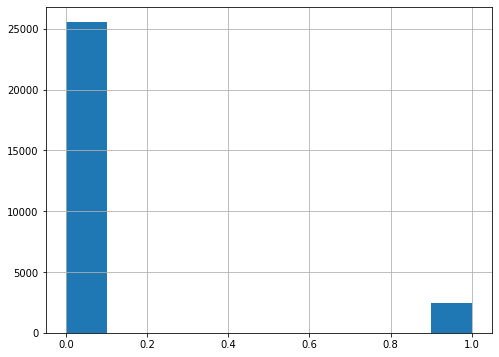

In [266]:
y_train.hist(figsize=(8, 6))

In [277]:
lr = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


lr.fit(train, y_train)



LogisticRegression(C=100, max_iter=3000, random_state=42)

In [278]:
lr.score(test, y_test)

0.9780419880034276

_**Voila! The predictor achieved an accuracy score of 97.8% on the test set.**_

## _Further Notes:_ 

1. The ML model I have built is able to predict values for n months ahead. For this competition, I have taken n_months to equal 6; for other n_months aside 6, the ipynb file should be re-run to reflect the changes in the features created.  


2. For useability, the stacked-model may be too complex and time consuming; the ExtraTree Model (et_reg) outperforms the stacked model (achieving a Private Leaderboard score of 672.), and should be used for the advantage of easy interpretability, quicker time and higher accuracy.  


3. The result can be improved on as most of the models were not automatically tuned by the required libraries due to low computational power.